# Import dependencies and load data

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib 
from matplotlib.ticker import FuncFormatter
from scipy import stats

In [24]:
ALL = pd.read_csv("data/ALL_6.20.25_newTask.csv").iloc[:,1:]
ALL = ALL.dropna()
ALL['times'] = pd.to_datetime(ALL['times'],format='%Y-%m-%d %H:%M:%S.%f',)             # any bad rows become NaT
ALL['day'] = ALL['times'].dt.normalize()   # midnight of each day
subject_IDs = np.sort(ALL.subjects.unique())
test_tag = 900263000259957
subject_IDs  = subject_IDs[subject_IDs != test_tag]
all_days = ALL["day"].dt.date.unique()

# find the two tasks
DURATION = ALL[ALL.task == 24].reset_index(drop=True)
SWEEPDIR = ALL[ALL.task == 29].reset_index(drop=True)

# special processing for SD_left bc data corruption
SWEEPDIR.drop(SWEEPDIR[SWEEPDIR["specific_stims"] == "clicks_32hz_1s_60db.wav"].index, inplace=True) 
ALL = pd.concat([DURATION, SWEEPDIR]).reset_index(drop=True)

In [25]:
# sanity check if the two rules are correct in the filtered data
# should have only two unique stimuli for each actioni in each rule
D_right = DURATION.loc[
    DURATION['trial_types'] == 1, 
    'specific_stims'
].unique()
D_left = DURATION.loc[
    DURATION['trial_types'] == 0, 
    'specific_stims'
].unique()
print(D_right)
print(D_left)

SD_right = SWEEPDIR.loc[
    SWEEPDIR['trial_types'] == 1, 
    'specific_stims'
].unique()
SD_left = SWEEPDIR.loc[
    SWEEPDIR['trial_types'] == 0, 
    'specific_stims'
].unique()
print(SD_right)
print(SD_left)

['fm_50ms_-40octs.wav' 'fm_50ms_+40octs.wav']
['fm_100ms_+40octs.wav' 'fm_100ms_-40octs.wav']
['fm_100ms_-40octs.wav' 'fm_50ms_-40octs.wav']
['fm_50ms_+40octs.wav' 'fm_100ms_+40octs.wav']


In [4]:
#                      Duration short 50ms (RIGHT 24)    Duration long 100ms (LEFT 23)        
# SD neg -40 (RIGHT 24)     (context-invariant)            (context-dependent)
# SR pos +40 (LEFT 23)     (context-dependent)             (context-invariant)  

# the invariant stimuli are: 'fm_50ms_-40octs.wav', 'fm_100ms_+40octs.wav'
# the context-dependent stimuli are: 'fm_50ms_+40octs.wav', 'fm_100ms_-40octs.wav' 

In [26]:
# load context-dependent and invariant trials for each task
INVARIANT_DURATION = DURATION[
    (DURATION['specific_stims'] == 'fm_50ms_-40octs.wav')
    | 
    (DURATION['specific_stims'] == 'fm_100ms_+40octs.wav')
]
DEPENDENT_DURATION = DURATION[
    (DURATION['specific_stims'] == 'fm_50ms_+40octs.wav')
    | 
    (DURATION['specific_stims'] == 'fm_100ms_-40octs.wav')
]

INVARIANT_SWEEPDIR = SWEEPDIR[
    (SWEEPDIR['specific_stims'] == 'fm_50ms_-40octs.wav')
    | 
    (SWEEPDIR['specific_stims'] == 'fm_100ms_+40octs.wav')
]
DEPENDENT_SWEEPDIR = SWEEPDIR[
    (SWEEPDIR['specific_stims'] == 'fm_50ms_+40octs.wav')
    | 
    (SWEEPDIR['specific_stims'] == 'fm_100ms_-40octs.wav')
]

In [6]:
colors = ['#FFC07F', # Arena A -> duration
          '#94c47d', #  Arena B -> sweep rate
          '#4AA9FC', # context-dep
          "#A1A7B0"] # context-inv

# plot the overall performance in both tasks

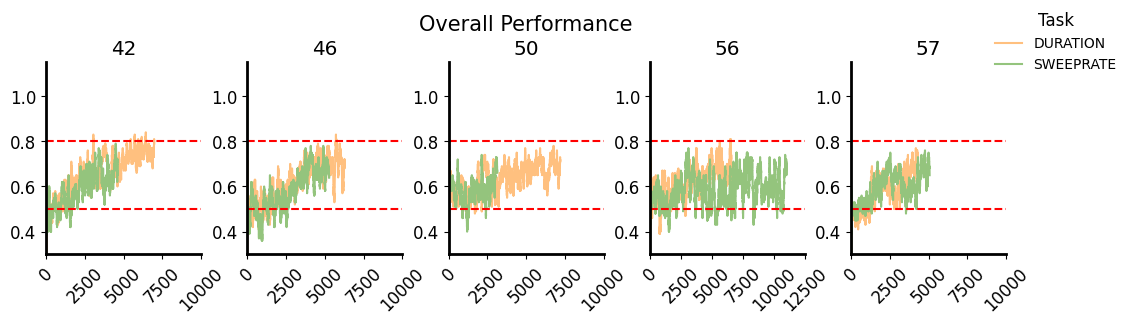

In [ ]:
fig = plt.figure(figsize=(12, 6))
roll_size = 100
import matplotlib 
import math
matplotlib.rcParams['font.size'] = 12
idx = 1
for subject in subject_IDs:
    ax = plt.subplot(2,5, idx)
    
    if subject == 900263000259957:
        sub_sweepdir = SWEEPDIR.loc[SWEEPDIR.subjects == subject].reset_index(drop=True)
        sub_duration = DURATION.loc[DURATION.subjects == subject].reset_index(drop=True)
        sub_duration.outcomes.rolling(5, min_periods=1).mean().plot(ax=ax,label="DURATION", color=colors[0])
        sub_sweepdir.outcomes.rolling(5, min_periods=1).mean().plot(ax=axes[idx],label="SWEEPRATE", color=colors[1])
        plt.title(f'{str(subject)[-3:]}')
        idx += 1
        axes[idx].axhline(0.8, color='red', ls='--')
        ax.axhline(0.5, color='red', ls='--')
        x_max = max(len(sub_duration), len(sub_sweepdir))
        lim_x = 100
        ax.set_xlim(0, lim_x) 
        ax.set_xticks(np.arange(0, lim_x+1, 10))
        ax.set_xticklabels(ax.get_xticks(), rotation=45)
        ax.set_ylim(0.3, 1.15)  
        ax.set_yticks(np.arange(0.4, 1.1, 0.2))

        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    else:
        sub_sweepdir = SWEEPDIR.loc[SWEEPDIR.subjects == subject].reset_index(drop=True)
        sub_duration = DURATION.loc[DURATION.subjects == subject].reset_index(drop=True)
        sub_duration.outcomes.rolling(roll_size, min_periods=1).mean().plot(ax=ax,label="DURATION", color=colors[0])
        sub_sweepdir.outcomes.rolling(roll_size, min_periods=1).mean().plot(ax=ax,label="SWEEPRATE", color=colors[1])
        plt.title(f'{str(subject)[-2:]}')
        idx += 1
        ax.axhline(0.8, color='red', ls='--')
        ax.axhline(0.5, color='red', ls='--')
        x_max = max(len(sub_duration), len(sub_sweepdir))
        if x_max < 10000:
            lim_x = 10000
        else:
            lim_x = math.ceil(x_max / 2500) * 2500
        ax.set_xlim(0, lim_x) 
        ax.set_xticks(np.arange(0, lim_x+1, 2500))
        ax.set_xticklabels(ax.get_xticks(), rotation=45)
        ax.set_ylim(0.3, 1.15)  
        ax.set_yticks(np.arange(0.4, 1.1, 0.2))

        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

plt.subplots_adjust(
    hspace=0.5,    # increase vertical padding between rows
    wspace=0.3,    # horizontal padding (if multiple columns)
    top=0.9,       # leave 10% space at top
    bottom=0.1,    # leave 10% space at bottom
    left=0.1,      # 10% margin on left
    right=0.9      # 10% margin on right
)
plt.suptitle('Overall Performance', fontsize=15)
handles, labels = ax.get_legend_handles_labels()

# add a single legend for the whole figure
fig.legend(
    handles,
    labels,
    loc='upper right',    # position above all subplots
    ncol=1,                # number of columns in the legend
    title='Task',
    fontsize = 10,
    frameon = False
)
plt.show()

# Performance across days

**Overall**

/var/folders/nn/8m_833q103bgc9nrgbf5_d500000gn/T/ipykernel_82289/1858035988.py:61: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


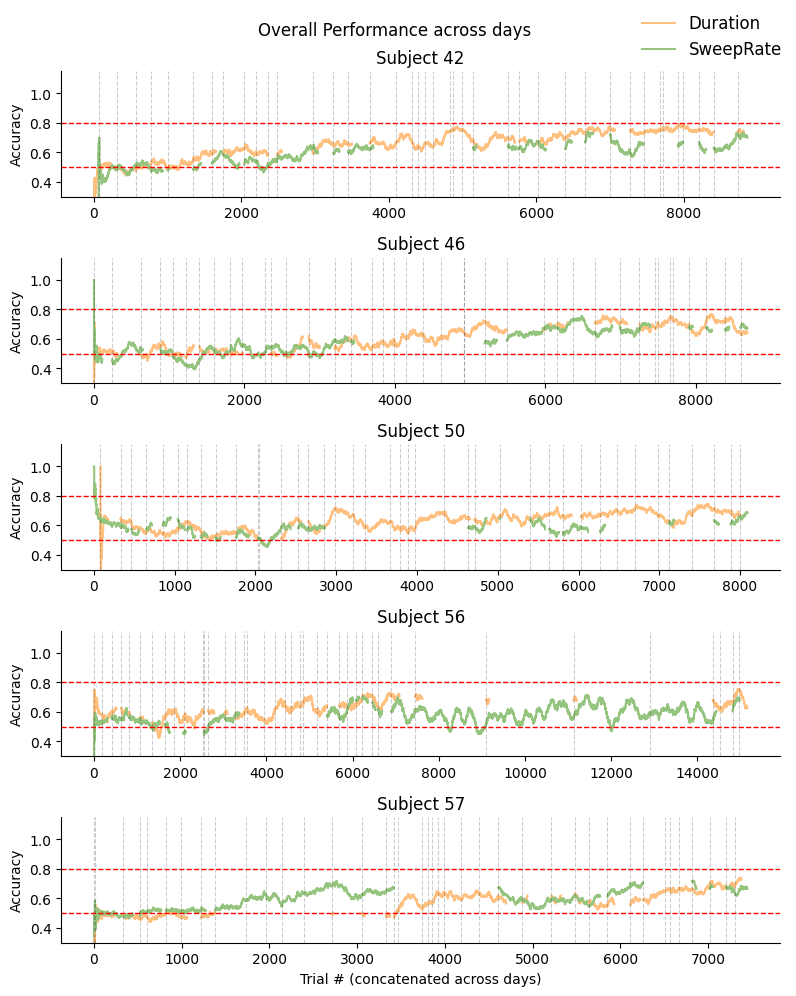

In [32]:
roll_size = 200
matplotlib.rcParams['font.size'] = 10

fig, axes = plt.subplots(nrows = 5, ncols = 1, figsize=(8, 10), constrained_layout = True)

for idx, subject in enumerate(subject_IDs):
    offset = 0                               # how many trials have we already placed?
    boundaries = []                          # collect (x-pos, date) tuples for later

    subject_data_Dur = DURATION.loc[DURATION .subjects == subject].reset_index(drop=True)
    subject_data_SR = SWEEPDIR.loc[SWEEPDIR .subjects == subject].reset_index(drop=True)

    subject_data_Dur['roll_means'] = subject_data_Dur.outcomes.rolling(roll_size, min_periods=1).mean()
    subject_data_SR['roll_means'] = subject_data_SR.outcomes.rolling(roll_size, min_periods=1).mean()

    for day in all_days:                     # ⬅  make sure this list is chronological
        # --- slice one day ------------------------------------------------------
        sub_dur  = subject_data_Dur.loc[subject_data_Dur.day.dt.date == day].reset_index(drop=True)
        sub_sweep = subject_data_SR.loc[subject_data_SR.day.dt.date == day].reset_index(drop=True)

        # x coordinates shifted by the cumulative offset
        x_dur   = np.arange(offset, offset + len(sub_dur))
        x_sweep = np.arange(offset, offset + len(sub_sweep))

        # --- plot the two tasks -------------------------------------------------
        axes[idx].plot(x_dur,   sub_dur.roll_means,   color=colors[0])
        axes[idx].plot(x_sweep, sub_sweep.roll_means, color=colors[1])
        
        # --- prepare next loop --------------------------------------------------
        offset += max(len(sub_dur), len(sub_sweep))     # where next day will start
        boundaries.append((offset, day))                # remember this end position

    # ---------------------------------------------------------------------------
    # Draw vertical lines and put the date right above each one
    y_top = axes[idx].get_ylim()[1]          # current upper y-limit
    for x_pos, day in boundaries[:-1]:    # skip final boundary (end of last day)
        axes[idx].axvline(x_pos, color='k', lw=0.8, alpha=0.2, linestyle = '--')

    axes[idx].axhline(0.8, color='red', ls='--', lw=1)
    axes[idx].axhline(0.5, color='red', ls='--', lw=1)

    axes[idx].set_ylim(0.3, 1.15)
    axes[idx].set_yticks(np.arange(0.4, 1.1, 0.2))

    if idx == len(subject_IDs)-1:
        axes[idx].set_xlabel('Trial # (concatenated across days)')
    axes[idx].set_ylabel('Accuracy')
    axes[idx].set_title(f'Subject {str(subject)[-2:]}')

    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)

fig.suptitle('Overall Performance across days')
fig.legend(
    ['Duration', 'SweepRate'],
    loc='upper right',    # position above all subplots
    ncol=1,                # number of columns in the legend
    fontsize = 12,
    frameon = False
)
fig.tight_layout()
plt.show()

**Invariant**

/var/folders/nn/8m_833q103bgc9nrgbf5_d500000gn/T/ipykernel_82289/4147832416.py:61: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


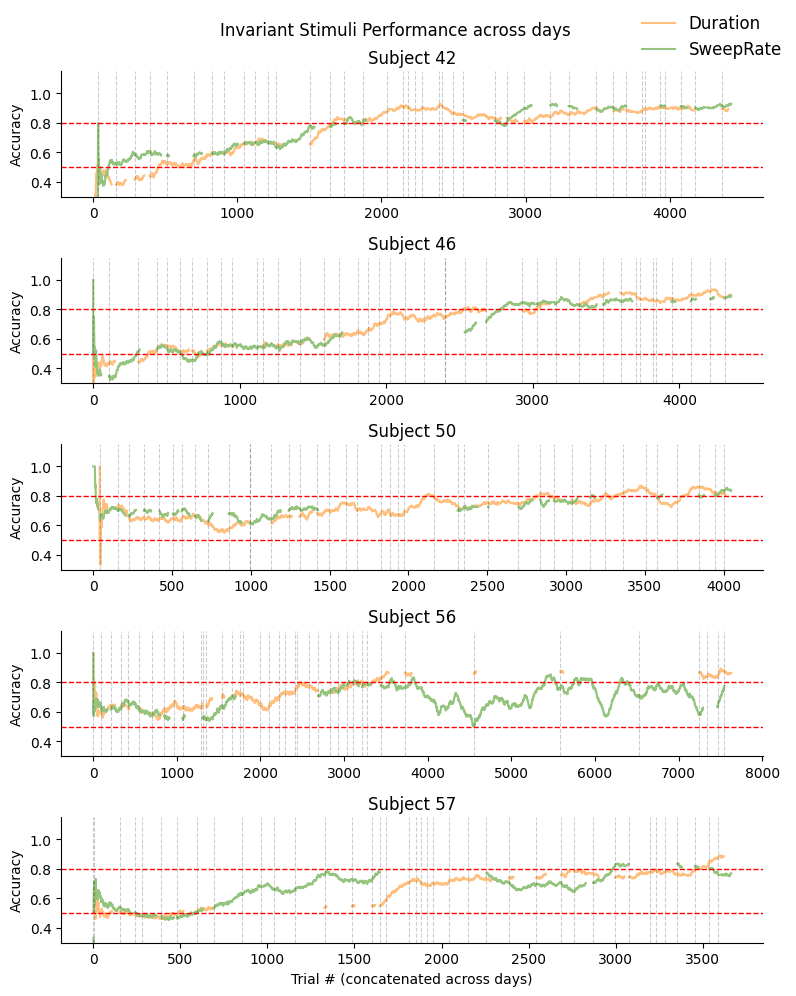

In [33]:
roll_size = 200
matplotlib.rcParams['font.size'] = 10

fig, axes = plt.subplots(nrows = 5, ncols = 1, figsize=(8, 10), constrained_layout = True)

for idx, subject in enumerate(subject_IDs):
    offset = 0                               # how many trials have we already placed?
    boundaries = []                          # collect (x-pos, date) tuples for later

    subject_data_Dur = INVARIANT_DURATION.loc[INVARIANT_DURATION .subjects == subject].reset_index(drop=True)
    subject_data_SR = INVARIANT_SWEEPDIR.loc[INVARIANT_SWEEPDIR .subjects == subject].reset_index(drop=True)

    subject_data_Dur['roll_means'] = subject_data_Dur.outcomes.rolling(roll_size, min_periods=1).mean()
    subject_data_SR['roll_means'] = subject_data_SR.outcomes.rolling(roll_size, min_periods=1).mean()

    for day in all_days:                     # ⬅  make sure this list is chronological
        # --- slice one day ------------------------------------------------------
        sub_dur  = subject_data_Dur.loc[subject_data_Dur.day.dt.date == day].reset_index(drop=True)
        sub_sweep = subject_data_SR.loc[subject_data_SR.day.dt.date == day].reset_index(drop=True)

        # x coordinates shifted by the cumulative offset
        x_dur   = np.arange(offset, offset + len(sub_dur))
        x_sweep = np.arange(offset, offset + len(sub_sweep))

        # --- plot the two tasks -------------------------------------------------
        axes[idx].plot(x_dur,   sub_dur.roll_means,   color=colors[0])
        axes[idx].plot(x_sweep, sub_sweep.roll_means, color=colors[1])
        
        # --- prepare next loop --------------------------------------------------
        offset += max(len(sub_dur), len(sub_sweep))     # where next day will start
        boundaries.append((offset, day))                # remember this end position

    # ---------------------------------------------------------------------------
    # Draw vertical lines and put the date right above each one
    y_top = axes[idx].get_ylim()[1]          # current upper y-limit
    for x_pos, day in boundaries[:-1]:    # skip final boundary (end of last day)
        axes[idx].axvline(x_pos, color='k', lw=0.8, alpha=0.2, linestyle = '--')

    axes[idx].axhline(0.8, color='red', ls='--', lw=1)
    axes[idx].axhline(0.5, color='red', ls='--', lw=1)

    axes[idx].set_ylim(0.3, 1.15)
    axes[idx].set_yticks(np.arange(0.4, 1.1, 0.2))

    if idx == len(subject_IDs)-1:
        axes[idx].set_xlabel('Trial # (concatenated across days)')
    axes[idx].set_ylabel('Accuracy')
    axes[idx].set_title(f'Subject {str(subject)[-2:]}')

    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)

fig.suptitle('Invariant Stimuli Performance across days')
fig.legend(
    ['Duration', 'SweepRate'],
    loc='upper right',    # position above all subplots
    ncol=1,                # number of columns in the legend
    fontsize = 12,
    frameon = False
)
fig.tight_layout()
plt.show()

**Dependent**

/var/folders/nn/8m_833q103bgc9nrgbf5_d500000gn/T/ipykernel_82289/1805798132.py:61: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


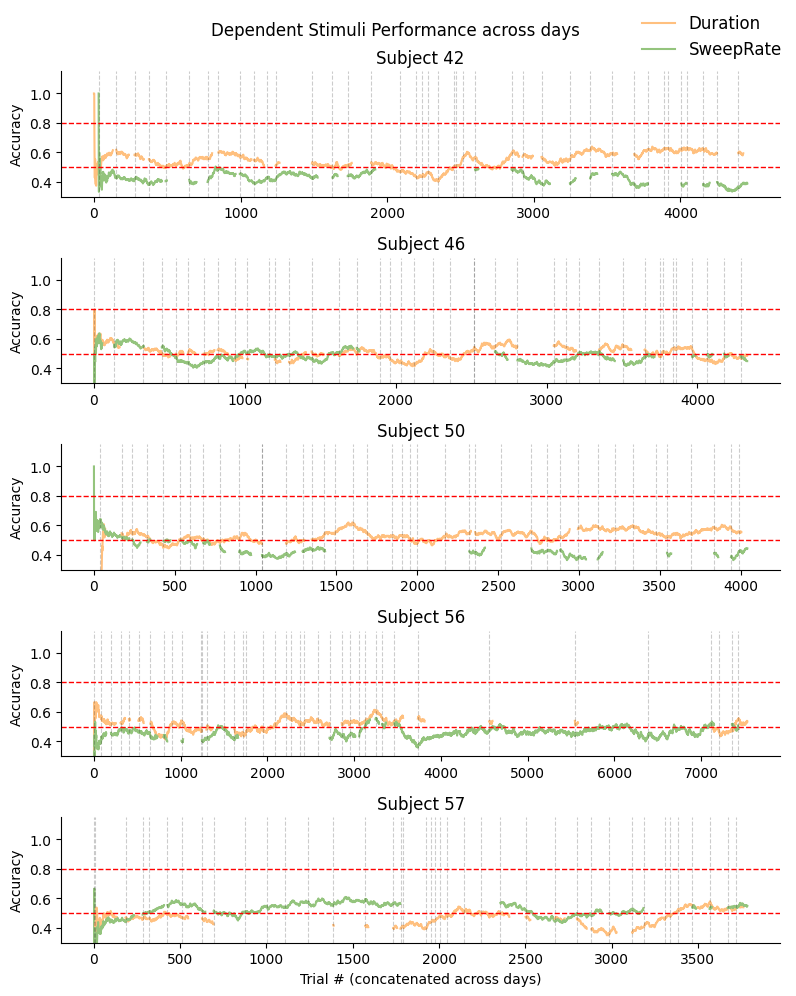

In [34]:
roll_size = 200
matplotlib.rcParams['font.size'] = 10

fig, axes = plt.subplots(nrows = 5, ncols = 1, figsize=(8, 10), constrained_layout = True)

for idx, subject in enumerate(subject_IDs):
    offset = 0                               # how many trials have we already placed?
    boundaries = []                          # collect (x-pos, date) tuples for later

    subject_data_Dur = DEPENDENT_DURATION.loc[DEPENDENT_DURATION .subjects == subject].reset_index(drop=True)
    subject_data_SR = DEPENDENT_SWEEPDIR.loc[DEPENDENT_SWEEPDIR .subjects == subject].reset_index(drop=True)

    subject_data_Dur['roll_means'] = subject_data_Dur.outcomes.rolling(roll_size, min_periods=1).mean()
    subject_data_SR['roll_means'] = subject_data_SR.outcomes.rolling(roll_size, min_periods=1).mean()

    for day in all_days:                     # ⬅  make sure this list is chronological
        # --- slice one day ------------------------------------------------------
        sub_dur  = subject_data_Dur.loc[subject_data_Dur.day.dt.date == day].reset_index(drop=True)
        sub_sweep = subject_data_SR.loc[subject_data_SR.day.dt.date == day].reset_index(drop=True)

        # x coordinates shifted by the cumulative offset
        x_dur   = np.arange(offset, offset + len(sub_dur))
        x_sweep = np.arange(offset, offset + len(sub_sweep))

        # --- plot the two tasks -------------------------------------------------
        axes[idx].plot(x_dur,   sub_dur.roll_means,   color=colors[0])
        axes[idx].plot(x_sweep, sub_sweep.roll_means, color=colors[1])
        
        # --- prepare next loop --------------------------------------------------
        offset += max(len(sub_dur), len(sub_sweep))     # where next day will start
        boundaries.append((offset, day))                # remember this end position

    # ---------------------------------------------------------------------------
    # Draw vertical lines and put the date right above each one
    y_top = axes[idx].get_ylim()[1]          # current upper y-limit
    for x_pos, day in boundaries[:-1]:    # skip final boundary (end of last day)
        axes[idx].axvline(x_pos, color='k', lw=0.8, alpha=0.2, linestyle = '--')

    axes[idx].axhline(0.8, color='red', ls='--', lw=1)
    axes[idx].axhline(0.5, color='red', ls='--', lw=1)

    axes[idx].set_ylim(0.3, 1.15)
    axes[idx].set_yticks(np.arange(0.4, 1.1, 0.2))

    if idx == len(subject_IDs)-1:
        axes[idx].set_xlabel('Trial # (concatenated across days)')
    axes[idx].set_ylabel('Accuracy')
    axes[idx].set_title(f'Subject {str(subject)[-2:]}')

    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)

fig.suptitle('Dependent Stimuli Performance across days')
fig.legend(
    ['Duration', 'SweepRate'],
    loc='upper right',    # position above all subplots
    ncol=1,                # number of columns in the legend
    fontsize = 12,
    frameon = False
)
fig.tight_layout()
plt.show()

# Plot Mice Choice of a chosen day

In [35]:
day = all_days[-1]

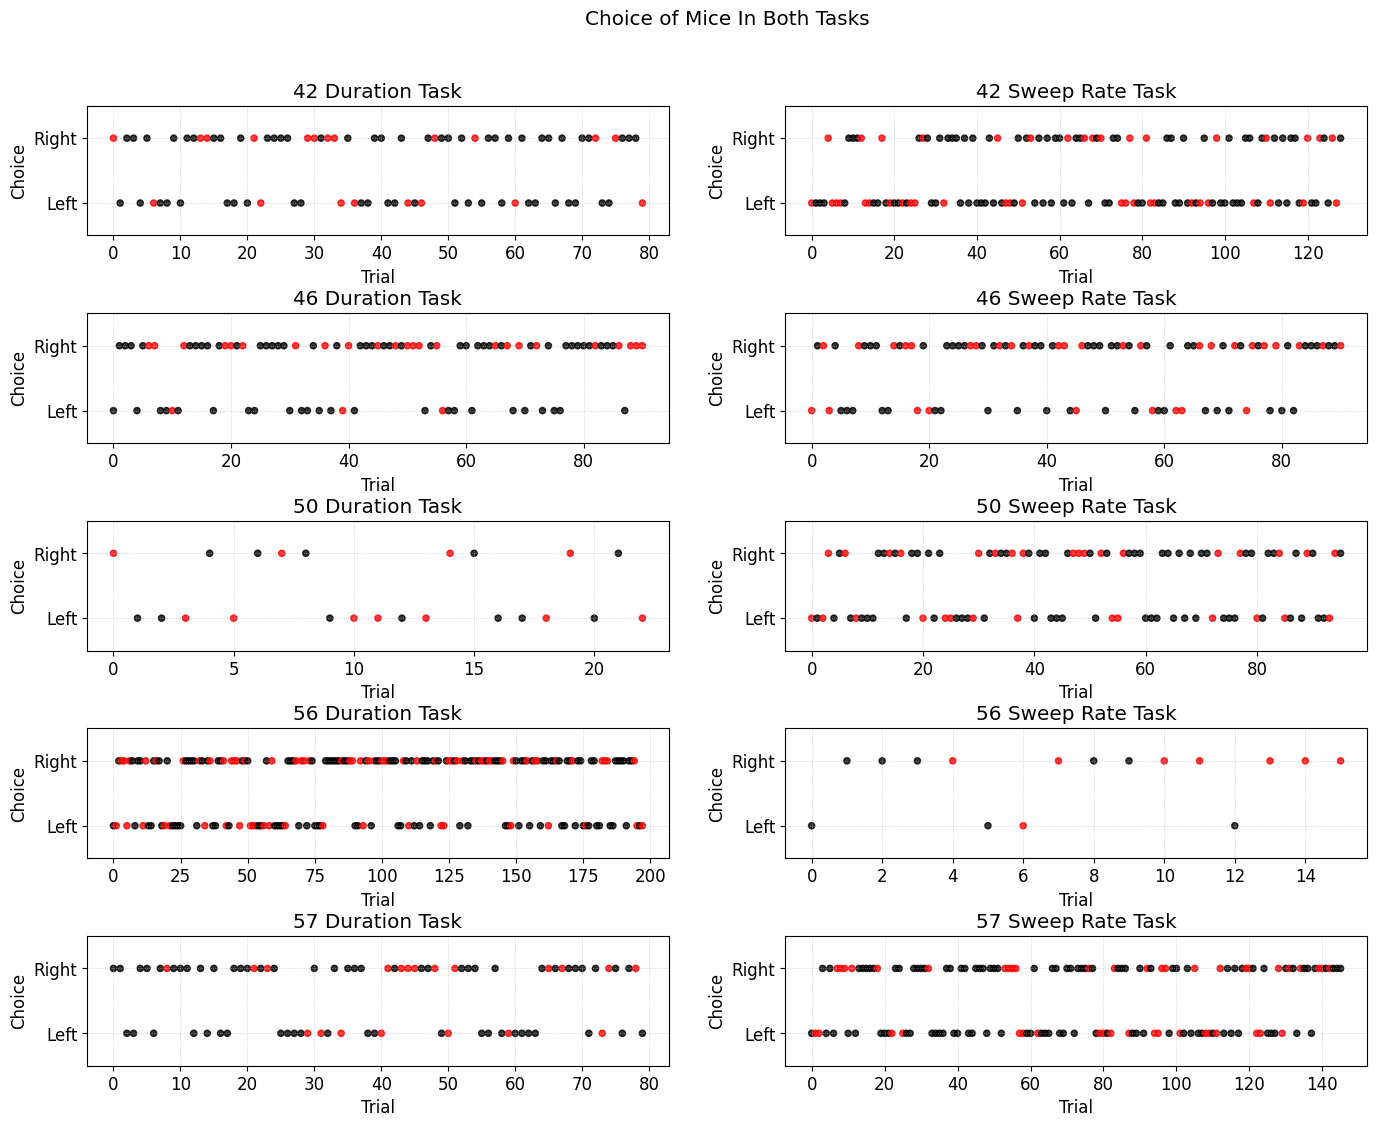

In [37]:
matplotlib.rcParams['font.size'] = 12

fig = plt.figure(figsize=(16, 12))
for subject_id, subject in enumerate(subject_IDs):
    
    subject_data_Dur = DURATION.loc[DURATION .subjects == subject].reset_index(drop=True)
    subject_data_SR = SWEEPDIR.loc[SWEEPDIR .subjects == subject].reset_index(drop=True)
    
    sub_dur  = subject_data_Dur.loc[subject_data_Dur.day.dt.date >= day].reset_index(drop=True)
    sub_sweep = subject_data_SR.loc[subject_data_SR.day.dt.date >= day].reset_index(drop=True)

    # duration task first 
    x_dur = sub_dur.get('trial', sub_dur.index)     # default: 0, 1, 2, …
    colors_dur = np.where(sub_dur['outcomes'] == 1, 'black', 'red')      
    
    ax1 = plt.subplot(5, 2, subject_id * 2 + 1)                          
    ax1.scatter(x_dur,
            sub_dur['choices'],    
            c=colors_dur,
            s=20,
            alpha=0.8)

    ax1.set_yticks([23, 24])
    ax1.set_yticklabels(['Left', 'Right'])
    ax1.set_xlabel('Trial')
    ax1.set_ylabel('Choice') 
    ax1.set_ylim(22.5, 24.5)                  # add a little padding so dots aren’t on the frame
    ax1.grid(True, axis='both', linestyle=':', linewidth=0.6, alpha=0.7)
    ax1.set_title(f'{str(subject)[-2:]} Duration Task')

    # click rate task
    x_sweep = sub_sweep.get('trial', sub_sweep.index)     # default: 0, 1, 2, …
    colors_sweep = np.where(sub_sweep['outcomes'] == 1, 'black', 'red')      
    ax2 = plt.subplot(5, 2, subject_id * 2 + 2)                          
    ax2.scatter(x_sweep,
            sub_sweep['choices'],    
            c=colors_sweep,
            s=20,
            alpha=0.8)

    ax2.set_yticks([23, 24])
    ax2.set_yticklabels(['Left', 'Right'])
    ax2.set_xlabel('Trial')
    ax2.set_ylabel('Choice') 
    ax2.set_ylim(22.5, 24.5)                  # add a little padding so dots aren’t on the frame
    ax2.grid(True, axis='both', linestyle=':', linewidth=0.6, alpha=0.7)
    ax2.set_title(f'{str(subject)[-2:]} Sweep Rate Task')

plt.suptitle('Choice of Mice In Both Tasks')
plt.subplots_adjust(
    hspace=0.6,    # increase vertical padding between rows
    wspace=0.2,    # horizontal padding (if multiple columns)
    top=0.9,       # leave 10% space at top
    bottom=0.1,    # leave 10% space at bottom
    left=0.1,      # 10% margin on left
    right=0.9      # 10% margin on right
)


**Plot Choice separately for context-dependent and -invariant stimuli**

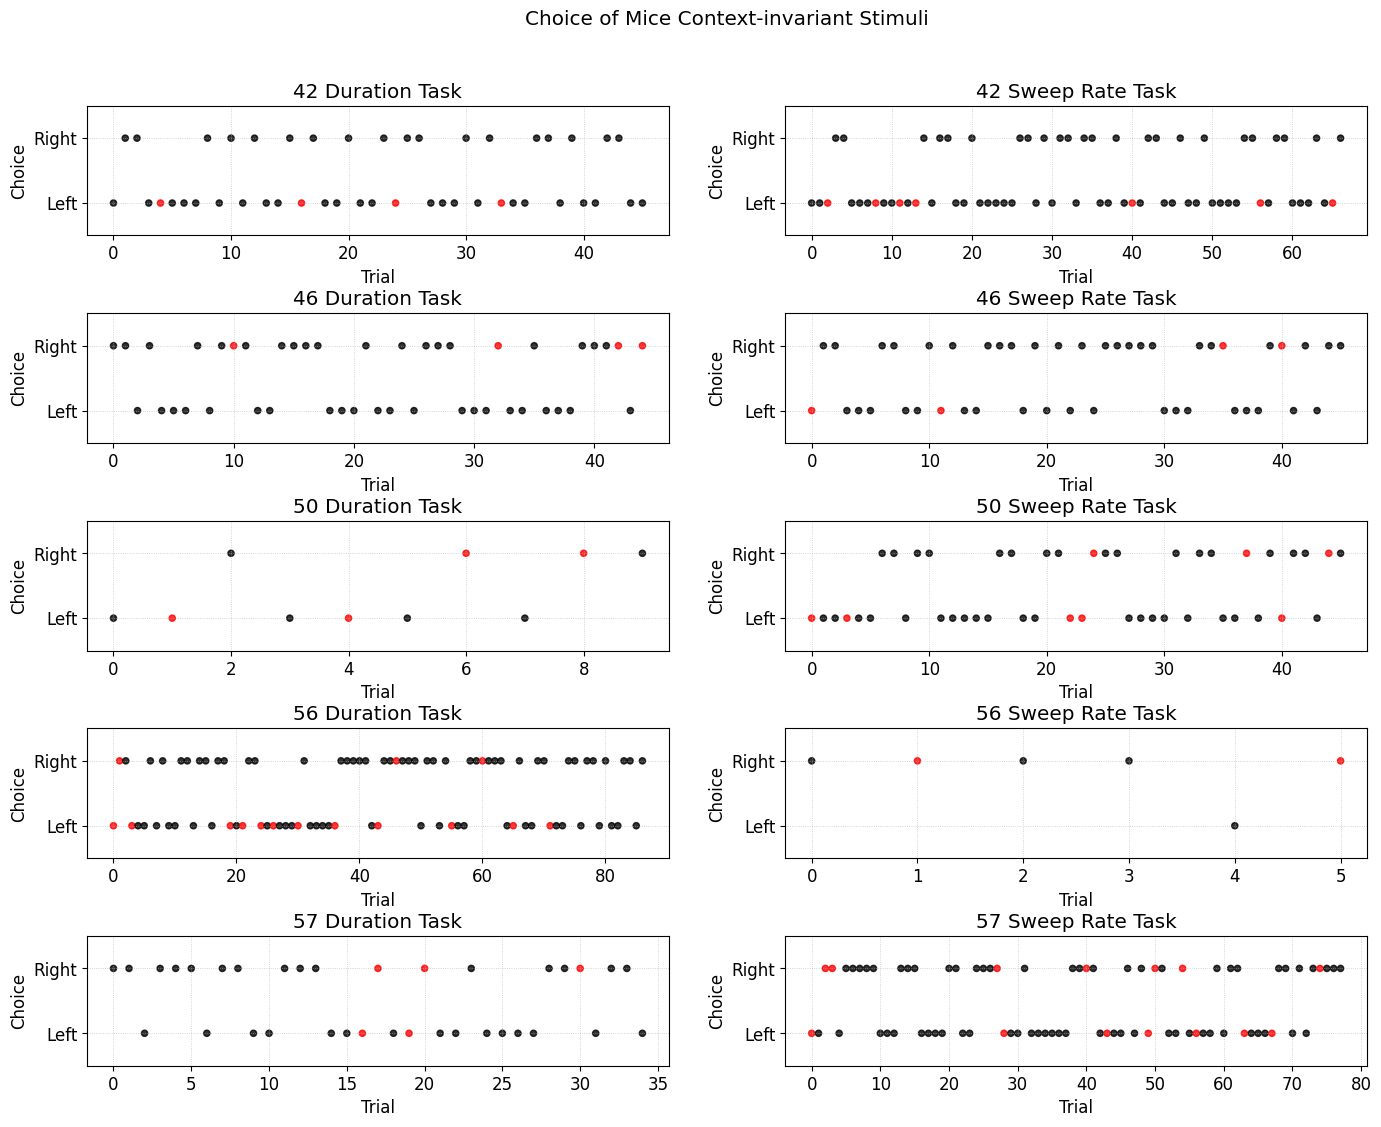

In [38]:
matplotlib.rcParams['font.size'] = 12

fig = plt.figure(figsize=(16, 12))
for subject_id, subject in enumerate(subject_IDs):
    
    subject_data_Dur = INVARIANT_DURATION.loc[INVARIANT_DURATION .subjects == subject].reset_index(drop=True)
    subject_data_SR = INVARIANT_SWEEPDIR.loc[INVARIANT_SWEEPDIR .subjects == subject].reset_index(drop=True)
    
    sub_dur  = subject_data_Dur.loc[subject_data_Dur.day.dt.date >= day].reset_index(drop=True)
    sub_sweep = subject_data_SR.loc[subject_data_SR.day.dt.date >= day].reset_index(drop=True)

    # duration task first 
    x_dur = sub_dur.get('trial', sub_dur.index)     # default: 0, 1, 2, …
    colors_dur = np.where(sub_dur['outcomes'] == 1, 'black', 'red')      
    
    ax1 = plt.subplot(5, 2, subject_id * 2 + 1)                          
    ax1.scatter(x_dur,
            sub_dur['choices'],    
            c=colors_dur,
            s=20,
            alpha=0.8)

    ax1.set_yticks([23, 24])
    ax1.set_yticklabels(['Left', 'Right'])
    ax1.set_xlabel('Trial')
    ax1.set_ylabel('Choice') 
    ax1.set_ylim(22.5, 24.5)                  # add a little padding so dots aren’t on the frame
    ax1.grid(True, axis='both', linestyle=':', linewidth=0.6, alpha=0.7)
    ax1.set_title(f'{str(subject)[-2:]} Duration Task')

    # click rate task
    x_sweep = sub_sweep.get('trial', sub_sweep.index)     # default: 0, 1, 2, …
    colors_sweep = np.where(sub_sweep['outcomes'] == 1, 'black', 'red')      
    ax2 = plt.subplot(5, 2, subject_id * 2 + 2)                          
    ax2.scatter(x_sweep,
            sub_sweep['choices'],    
            c=colors_sweep,
            s=20,
            alpha=0.8)

    ax2.set_yticks([23, 24])
    ax2.set_yticklabels(['Left', 'Right'])
    ax2.set_xlabel('Trial')
    ax2.set_ylabel('Choice') 
    ax2.set_ylim(22.5, 24.5)                  # add a little padding so dots aren’t on the frame
    ax2.grid(True, axis='both', linestyle=':', linewidth=0.6, alpha=0.7)
    ax2.set_title(f'{str(subject)[-2:]} Sweep Rate Task')

plt.suptitle('Choice of Mice Context-invariant Stimuli')
plt.subplots_adjust(
    hspace=0.6,    # increase vertical padding between rows
    wspace=0.2,    # horizontal padding (if multiple columns)
    top=0.9,       # leave 10% space at top
    bottom=0.1,    # leave 10% space at bottom
    left=0.1,      # 10% margin on left
    right=0.9      # 10% margin on right
)


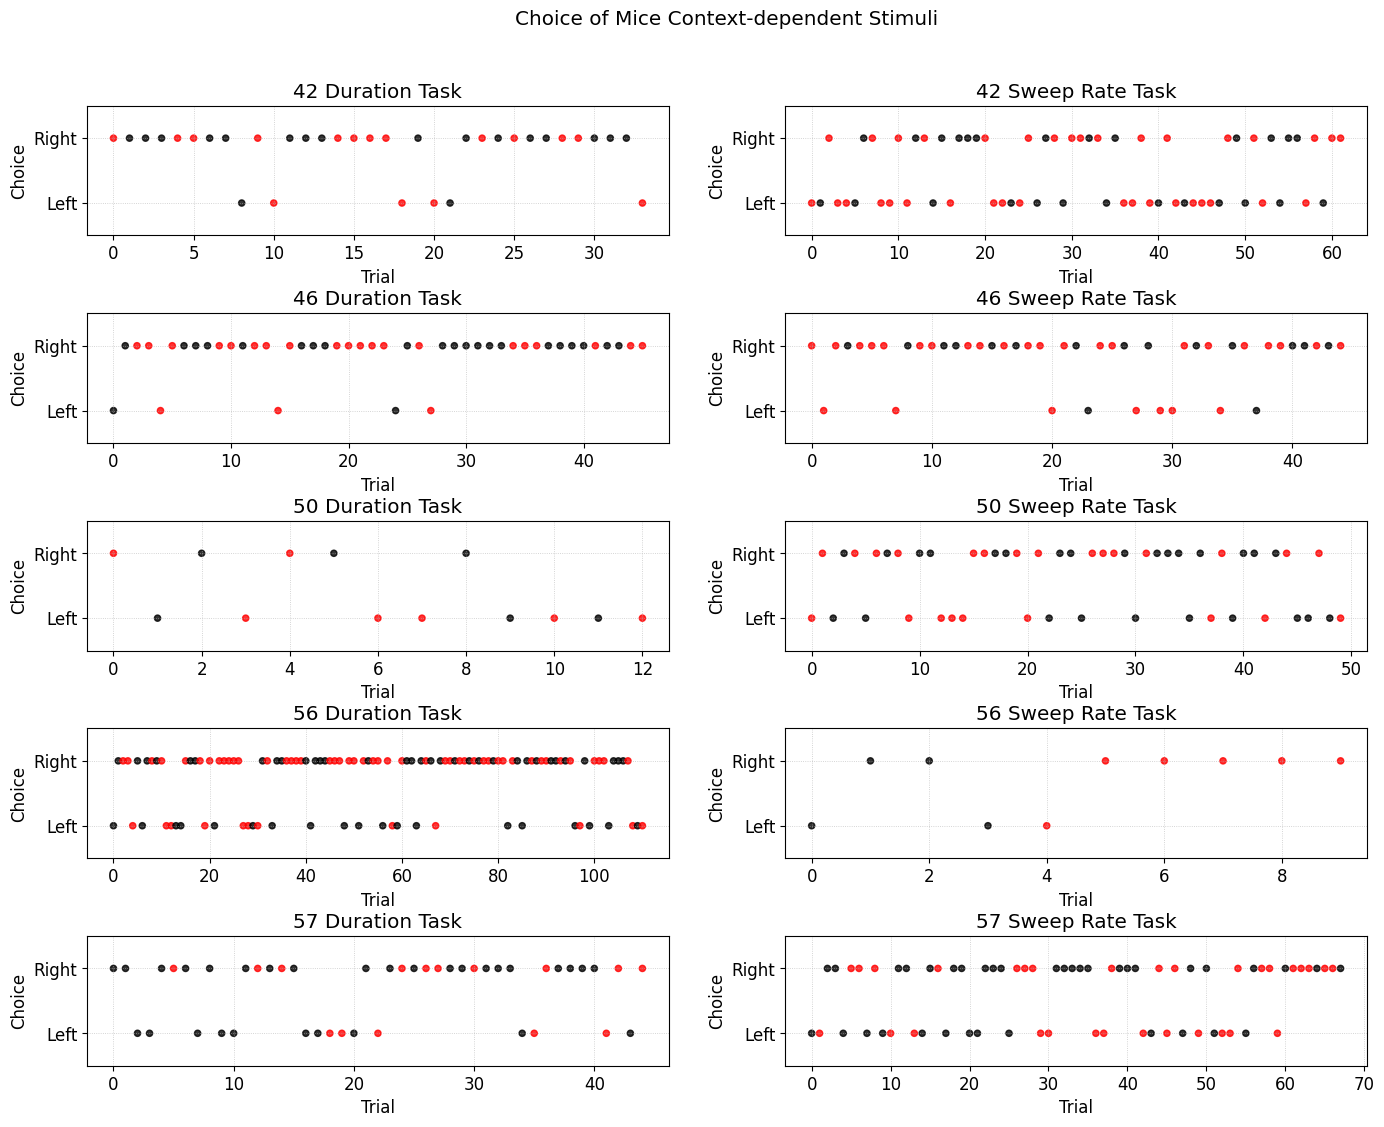

In [39]:
matplotlib.rcParams['font.size'] = 12

fig = plt.figure(figsize=(16, 12))
for subject_id, subject in enumerate(subject_IDs):
    
    subject_data_Dur = DEPENDENT_DURATION.loc[DEPENDENT_DURATION .subjects == subject].reset_index(drop=True)
    subject_data_SR = DEPENDENT_SWEEPDIR.loc[DEPENDENT_SWEEPDIR .subjects == subject].reset_index(drop=True)
    
    sub_dur  = subject_data_Dur.loc[subject_data_Dur.day.dt.date >= day].reset_index(drop=True)
    sub_sweep = subject_data_SR.loc[subject_data_SR.day.dt.date >= day].reset_index(drop=True)

    # duration task first 
    x_dur = sub_dur.get('trial', sub_dur.index)     # default: 0, 1, 2, …
    colors_dur = np.where(sub_dur['outcomes'] == 1, 'black', 'red')      
    
    ax1 = plt.subplot(5, 2, subject_id * 2 + 1)                          
    ax1.scatter(x_dur,
            sub_dur['choices'],    
            c=colors_dur,
            s=20,
            alpha=0.8)

    ax1.set_yticks([23, 24])
    ax1.set_yticklabels(['Left', 'Right'])
    ax1.set_xlabel('Trial')
    ax1.set_ylabel('Choice') 
    ax1.set_ylim(22.5, 24.5)                  # add a little padding so dots aren’t on the frame
    ax1.grid(True, axis='both', linestyle=':', linewidth=0.6, alpha=0.7)
    ax1.set_title(f'{str(subject)[-2:]} Duration Task')

    # click rate task
    x_sweep = sub_sweep.get('trial', sub_sweep.index)     # default: 0, 1, 2, …
    colors_sweep = np.where(sub_sweep['outcomes'] == 1, 'black', 'red')      
    ax2 = plt.subplot(5, 2, subject_id * 2 + 2)                          
    ax2.scatter(x_sweep,
            sub_sweep['choices'],    
            c=colors_sweep,
            s=20,
            alpha=0.8)

    ax2.set_yticks([23, 24])
    ax2.set_yticklabels(['Left', 'Right'])
    ax2.set_xlabel('Trial')
    ax2.set_ylabel('Choice') 
    ax2.set_ylim(22.5, 24.5)                  # add a little padding so dots aren’t on the frame
    ax2.grid(True, axis='both', linestyle=':', linewidth=0.6, alpha=0.7)
    ax2.set_title(f'{str(subject)[-2:]} Sweep Rate Task')

plt.suptitle('Choice of Mice Context-dependent Stimuli')
plt.subplots_adjust(
    hspace=0.6,    # increase vertical padding between rows
    wspace=0.2,    # horizontal padding (if multiple columns)
    top=0.9,       # leave 10% space at top
    bottom=0.1,    # leave 10% space at bottom
    left=0.1,      # 10% margin on left
    right=0.9      # 10% margin on right
)


# plot separately for context-dependent and -invariant stimuli

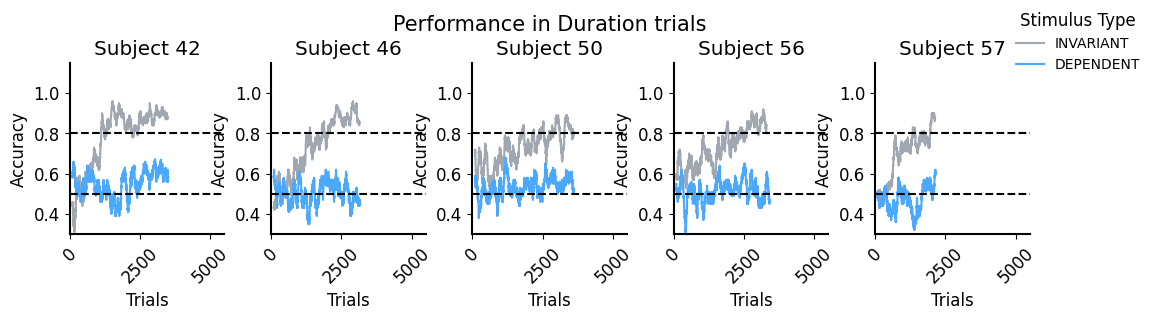

In [40]:
fig = plt.figure(figsize=(12, 6))
matplotlib.rcParams['font.size'] = 12
idx = 1
for subject in subject_IDs:
    ax = plt.subplot(2, 5, idx)
    if subject == 900263000259957:
        sub_inv_duration = INVARIANT_DURATION.loc[INVARIANT_DURATION.subjects == subject].reset_index(drop=True)
        sub_inv_duration.outcomes.rolling(5, min_periods=1).mean().plot(ax=ax,label="INVARIANT", color=colors[3])
        sub_dep_duration = DEPENDENT_DURATION.loc[DEPENDENT_DURATION.subjects == subject].reset_index(drop=True)
        sub_dep_duration.outcomes.rolling(5, min_periods=1).mean().plot(ax=ax,label="DEPENDENT", color=colors[2])
        plt.title(f'Subject {str(subject)[-3:]}')
        idx += 1
        ax.axhline(0.8, color='black', ls='--')
        ax.axhline(0.5, color='black', ls='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        x_max = max(len(sub_inv_duration), len(sub_dep_duration))
        lim_x = 50
        ax.set_xlim(0, lim_x) 
        ax.set_xticks(np.arange(0, lim_x+1, 10))
        ax.set_xticklabels(ax.get_xticks(), rotation=45)
        ax.set_ylim(0.3, 1.15)  
        ax.set_yticks(np.arange(0.4, 1.1, 0.2))
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Trials')
        ax.spines['bottom'].set_linewidth(1.5)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    else:
        sub_inv_duration = INVARIANT_DURATION.loc[INVARIANT_DURATION.subjects == subject].reset_index(drop=True)
        sub_inv_duration.outcomes.rolling(100).mean().plot(ax=ax,label="INVARIANT", color=colors[3])
        sub_dep_duration = DEPENDENT_DURATION.loc[DEPENDENT_DURATION.subjects == subject].reset_index(drop=True)
        sub_dep_duration.outcomes.rolling(100).mean().plot(ax=ax,label="DEPENDENT", color=colors[2])
        plt.title(f'Subject {str(subject)[-2:]}')
        idx += 1
        ax.axhline(0.8, color='black', ls='--')
        ax.axhline(0.5, color='black', ls='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        x_max = max(len(sub_inv_duration), len(sub_dep_duration))
        if x_max < 5500:
            lim_x = 5500
        else:
            lim_x = math.ceil(x_max / 2500) * 2500
        ax.set_xlim(0, lim_x) 
        ax.set_xticks(np.arange(0, lim_x+1, 2500))
        ax.set_xticklabels(ax.get_xticks(), rotation=45)
        ax.set_ylim(0.3, 1.15)  
        ax.set_yticks(np.arange(0.4, 1.1, 0.2))
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Trials')
        ax.spines['bottom'].set_linewidth(1.5)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)


plt.subplots_adjust(
    hspace=0.8,    # increase vertical padding between rows
    wspace=0.3,    # horizontal padding (if multiple columns)
    top=0.9,       # leave 10% space at top
    bottom=0.1,    # leave 10% space at bottom
    left=0.1,      # 10% margin on left
    right=0.9      # 10% margin on right
)
plt.suptitle('Performance in Duration trials', fontsize=15)
# collect handles + labels from the last axes (or any one axes—it’s the same labels)
handles, labels = ax.get_legend_handles_labels()

# add a single legend for the whole figure
fig.legend(
    handles,
    labels,
    loc='upper right',    # position above all subplots
    ncol=1,                # number of columns in the legend
    title='Stimulus Type',
    fontsize = 10,
    frameon = False
)
plt.show()

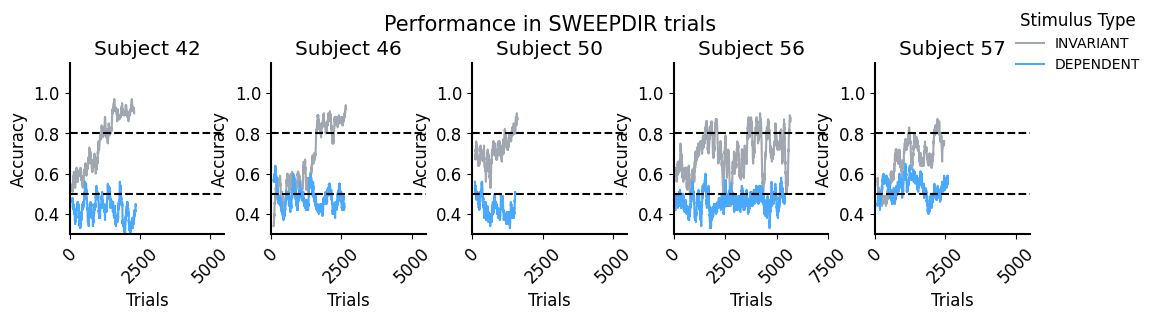

In [41]:
# # plot separately for context-dependent and -invariant stimuli in SWEEPDIR trials
fig = plt.figure(figsize=(12, 6))
matplotlib.rcParams['font.size'] = 12
idx = 1
for subject in subject_IDs:
    ax = plt.subplot(2, 5, idx)
    if subject == 900263000259957:
        sub_inv_sweepdir = INVARIANT_SWEEPDIR.loc[INVARIANT_SWEEPDIR.subjects == subject].reset_index(drop=True)
        sub_inv_sweepdir.outcomes.rolling(5, min_periods=1).mean().plot(ax=ax,label="INVARIANT", color=colors[3])
        sub_dep_sweepdir = DEPENDENT_SWEEPDIR.loc[DEPENDENT_SWEEPDIR.subjects == subject].reset_index(drop=True)
        sub_dep_sweepdir.outcomes.rolling(5, min_periods=1).mean().plot(ax=ax,label="DEPENDENT", color=colors[2])
        plt.title(f'Subject {str(subject)[-3:]}')
        idx += 1
        ax.axhline(0.8, color='black', ls='--')
        ax.axhline(0.5, color='black', ls='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        x_max = max(len(sub_inv_sweepdir), len(sub_dep_sweepdir))
        lim_x = 50
        ax.set_xlim(0, lim_x) 
        ax.set_xticks(np.arange(0, lim_x+1, 10))
        ax.set_xticklabels(ax.get_xticks(), rotation=45)
        ax.set_ylim(0.3, 1.15)  
        ax.set_yticks(np.arange(0.4, 1.1, 0.2))
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Trials')
        ax.spines['bottom'].set_linewidth(1.5)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    else:
        sub_inv_sweepdir = INVARIANT_SWEEPDIR.loc[INVARIANT_SWEEPDIR.subjects == subject].reset_index(drop=True)
        sub_inv_sweepdir.outcomes.rolling(100).mean().plot(ax=ax,label="INVARIANT", color=colors[3])
        sub_dep_sweepdir = DEPENDENT_SWEEPDIR.loc[DEPENDENT_SWEEPDIR.subjects == subject].reset_index(drop=True)
        sub_dep_sweepdir.outcomes.rolling(100).mean().plot(ax=ax,label="DEPENDENT", color=colors[2])
        plt.title(f'Subject {str(subject)[-2:]}')
        idx += 1
        ax.axhline(0.8, color='black', ls='--')
        ax.axhline(0.5, color='black', ls='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        x_max = max(len(sub_inv_sweepdir), len(sub_dep_sweepdir))
        if x_max < 5500:
            lim_x = 5500
        else:
            lim_x = math.ceil(x_max / 2500) * 2500
        ax.set_xlim(0, lim_x) 
        ax.set_xticks(np.arange(0, lim_x+1, 2500))
        ax.set_xticklabels(ax.get_xticks(), rotation=45)
        ax.set_ylim(0.3, 1.15)  
        ax.set_yticks(np.arange(0.4, 1.1, 0.2))
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Trials')
        ax.spines['bottom'].set_linewidth(1.5)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
plt.subplots_adjust(
    hspace=0.8,    # increase vertical padding between rows
    wspace=0.3,    # horizontal padding (if multiple columns)
    top=0.9,       # leave 10% space at top
    bottom=0.1,    # leave 10% space at bottom
    left=0.1,      # 10% margin on left
    right=0.9      # 10% margin on right
)
plt.suptitle('Performance in SWEEPDIR trials', fontsize=15)
# collect handles + labels from the last axes (or any one axes—it’s the same labels)
handles, labels = ax.get_legend_handles_labels()

# add a single legend for the whole figure
fig.legend(
    handles,
    labels,
    loc='upper right',    # position above all subplots
    ncol=1,                # number of columns in the legend
    title='Stimulus Type',
    fontsize=10,
    frameon = False
)
plt.show()

# Plot the swith frequency and initial performance

In [43]:
'''Helper functions'''
def process_block_data(subject_data):
    subject_data = subject_data.sort_values("times").reset_index(drop=True)
    subject_data["trial_idx"] = subject_data.index

    # (a) contiguous-block labels
    subject_data['block_id'] = subject_data['task'].ne(
        subject_data['task'].shift()
    ).cumsum()

    # (b) trial index *within* each block
    subject_data['within_block_idx'] = (
        subject_data
        .groupby('block_id')
        .cumcount()
    )

    # (c) block length for every trial 
    block_len = (
        subject_data.groupby('block_id')
        .size()
        .rename('block_len')
    )
    subject_data_processed = subject_data.join(block_len, on='block_id')
    return subject_data_processed

def boxplot_trialnum(subject_data_processed, subject, ax):
    block_len_df = (
        subject_data_processed[['task', 'block_id', 'block_len']]
        .drop_duplicates()
        .reset_index(drop=True)
    )

    Duration_len = block_len_df.loc[block_len_df['task'] == 24, 'block_len']
    SweepRate_len = block_len_df.loc[block_len_df['task'] == 29, 'block_len']
    data = [Duration_len, SweepRate_len]

    palette = {24: colors[0], 29: colors[1]} 

    bp = ax.boxplot(
        data,
        patch_artist=True,
        widths=0.6,
        positions=[1.0, 1.75],
        boxprops    = dict(edgecolor='black',linewidth = 1.5),
        medianprops = dict(color='black', linewidth=1.5),
        whiskerprops= dict(color='black'),
        capprops    = dict(color='black')
    )

    box_colors = [palette[24], palette[29]]
    for box, col in zip(bp['boxes'], box_colors):
        box.set_facecolor(col)
        box.set_alpha(0.8) 

    rng      = np.random.default_rng(1)
    jitter   = 0
    dot_area = 55

    # Duration dots (blue)
    x24 = 1 + rng.uniform(-jitter, jitter, len(Duration_len))
    ax.scatter(
        x24, Duration_len,
        marker='o',
        s=dot_area,
        facecolors=palette[24],   # your blue
        edgecolors='black',
        linewidths=0.8,
        zorder=2
    )

    # SweepRate dots (orange)
    x29 = 1.75 + rng.uniform(-jitter, jitter, len(SweepRate_len))
    ax.scatter(
        x29, SweepRate_len,
        marker='o',
        s=dot_area,
        facecolors=palette[29],   # your orange
        edgecolors='black',
        linewidths=0.8,
        zorder=2
    )
    ax.set_title(f'Subject {str(subject)[-2:]}')
    # ax.set_ylim([-100,750])
    ax.set_xlim([0.5, 2.1])
    ax.set_xticklabels(['Arena A', 'Arena B'], fontsize = 8)
    ax.set_ylabel('# trials before switch')
    ax.grid(axis='y', linestyle='--', alpha=0.35)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.tight_layout()
    # plt.savefig('figures/switch_frequency.pdf',bbox_inches='tight')
    # plt.show()
    return Duration_len, SweepRate_len
    
def trial_length_average_and_ttest(Duration_len, SweepRate_len):
    t_stat, p_val = stats.ttest_ind(Duration_len, SweepRate_len, equal_var=False)  # Welch’s t-test
    if p_val > 0.05:
        print(f'Subject stays in either arena does NOT significantly differ: t = {t_stat:.3f},  p = {p_val:.4f}')
    else:
        print(f'Subject stays in either arena DOES significantly differ: t = {t_stat:.3f},  p = {p_val:.4f}')
    Duration_len_mean = np.mean(Duration_len)
    Duration_len_se = Duration_len.std(ddof=1) / np.sqrt(len(Duration_len))
    SweepRate_len_mean = np.mean(SweepRate_len)
    SweepRate_len_se = SweepRate_len.std(ddof=1) / np.sqrt(len(SweepRate_len))
    print(f'Duration task on average runs for {Duration_len_mean} trials ± {Duration_len_se:.2f}, the range is [{min(Duration_len)},{max(Duration_len)}]')
    print(f'SweepRate task on average runs for {SweepRate_len_mean} trials ± {SweepRate_len_se:.2f}, the range is [{min(SweepRate_len)},{max(SweepRate_len)}]\n')

def plot_afterswitch_performance(subject_data, subject, ax, max_k = 20):
    palette = {24: colors[0], 29: colors[1]} 
    trimmed = subject_data[subject_data['within_block_idx'] < max_k].copy()

    summ = (
        trimmed
        .groupby(['task', 'within_block_idx'])['outcomes']
        .agg(mean='mean', count='count', std='std')
        .reset_index()
    )
    summ['sem'] = summ['std'] / np.sqrt(summ['count'])

    #smoothing
    for col in ['mean', 'sem']:
        summ[f'smooth_{col}'] = (
            summ
            .groupby('task')[col]
            .transform(lambda s: s.rolling(3,
                                            center=True,
                                            min_periods=1).mean())
        )

    for task_val in (24, 29):
        g  = summ[summ['task'] == task_val]
        x  = g['within_block_idx']
        m  = g['smooth_mean']
        se = g['smooth_sem']
        cur_label = 'Arena A' if task_val == 24 else 'Arena B'
        ax.plot(x, m, color=palette[task_val], label=cur_label)
        ax.fill_between(x, m - se, m + se,
                        color=palette[task_val], alpha=0.25)
    ax.set_title(f'Subject {str(subject)[-2:]}')
    ax.axhline(0.8, color='red', ls='--')
    ax.axhline(0.5, color='black', ls='--')
    ax.set_xlim(-0.5, max_k - 0.5)
    ax.set_xlabel('Trials', fontsize = 9)
    ax.set_ylabel('Accuracy',fontsize = 9)
    ax.set_ylim(0.3, 1.15)  
    ax.set_yticks(np.arange(0.4, 1.1, 0.2))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.tight_layout()
    # plt.savefig('figures/after_switch_accuray.pdf',bbox_inches='tight')
    # plt.show()


Subject stays in either arena does NOT significantly differ: t = 1.156,  p = 0.2536
Duration task on average runs for 199.57142857142858 trials ± 49.57, the range is [31,1661]
SweepRate task on average runs for 136.5 trials ± 22.83, the range is [5,601]

Subject stays in either arena does NOT significantly differ: t = 0.477,  p = 0.6358
Duration task on average runs for 161.43589743589743 trials ± 51.05, the range is [7,1959]
SweepRate task on average runs for 135.4102564102564 trials ± 19.38, the range is [5,503]

Subject stays in either arena DOES significantly differ: t = 2.029,  p = 0.0491
Duration task on average runs for 200.05555555555554 trials ± 54.96, the range is [15,1813]
SweepRate task on average runs for 84.75675675675676 trials ± 14.39, the range is [4,441]

Subject stays in either arena does NOT significantly differ: t = -1.171,  p = 0.2425
Duration task on average runs for 39.55882352941177 trials ± 12.94, the range is [1,1957]
SweepRate task on average runs for 65.023

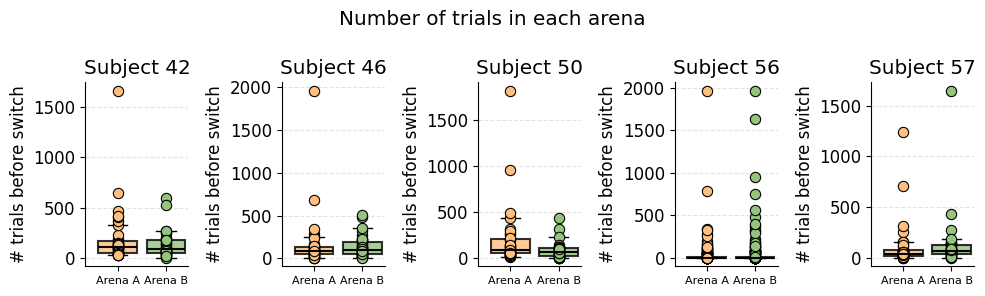

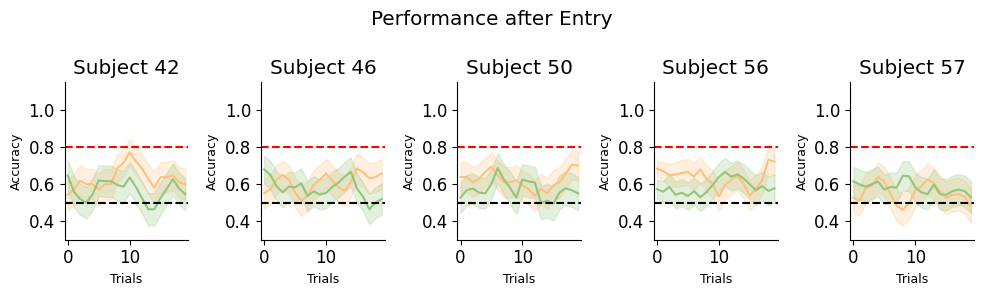

In [44]:
fig1, axgrid1 = plt.subplots(1, 5, figsize=(10, 3))   # box-plots
fig2, axgrid2 = plt.subplots(1, 5, figsize=(10, 3))   # after-switch curves

matplotlib.rcParams['font.size'] = 12
for idx, subject in enumerate(subject_IDs):
    # row, col = divmod(idx, 5)
    
    ax1   = axgrid1[idx]      
    ax2 = axgrid2[idx] 

    subject_data = ALL.loc[ALL.subjects == subject].reset_index(drop=True)
    subject_data_processed = process_block_data(subject_data)
    Duration_len, SweepRate_len = boxplot_trialnum(subject_data_processed, subject, ax1)
    trial_length_average_and_ttest(Duration_len, SweepRate_len)
    plot_afterswitch_performance(subject_data_processed, subject, ax2)

fig1.suptitle('Number of trials in each arena')
fig1.tight_layout()
fig2.suptitle('Performance after Entry')
fig2.tight_layout()

plt.show()